# Debugging #

In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import h5py
import numpy as np
import class_utils as class_utils
from class_grid import Grid
from class_params import Params
from class_groundstate import groundstate
from class_excitations import excitations
from class_vertices import vertices
from class_perturbation import perturbative
from class_self_energy import Self_Energy
from class_io import IO
from class_plotting import plot2D, plot_cns, plot_omega0
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker


### For different hopping values

In [2]:
config_path = "config.yml" 

muU = 0.41#np.sqrt(2) - 1 # which chemical potential we are fixing to

output_dir = class_utils.create_output_dir()
config = class_utils.read_config(config_path)

Lx = config["grid"]["Lx"]
Ly = config["grid"]["Ly"]
cutoff = config["physics"]["cutoff"]
N = config["physics"]["N"]
UIB = config["physics"]["UIB"]
M = Lx * Ly

grid = Grid(Lx, Ly)

num_en = 100 # 100 gets pretty good resolution.  takes at least an hour then.
num_dJU = 10 # 100
dJU_max = 0.5
en_vector = np.linspace(0.001,0.5,num_en) #0.001, 0.5,num_en)
dJUs = np.linspace(0, dJU_max, num_dJU)

In [3]:
omega0s = np.zeros(len(dJUs))
omega1s = np.zeros(len(dJUs))
omega2s = np.zeros(len(dJUs))

SE = np.zeros((7, len(en_vector)), dtype=np.complex128)  #7 rows for each contribution, num_en columns ##V: why 7?


#V:  Add poles to this plot!!!
T11 = np.zeros((len(dJUs), len(en_vector)), dtype=np.complex128)
T12 = np.zeros((len(dJUs), len(en_vector)), dtype=np.complex128)
T21 = np.zeros((len(dJUs), len(en_vector)), dtype=np.complex128)
T22 = np.zeros((len(dJUs), len(en_vector)), dtype=np.complex128)
T22_F = np.zeros((len(dJUs), len(en_vector)), dtype=np.complex128)
SE_SI = np.zeros((len(dJUs), len(en_vector)), dtype=np.complex128)

for count, dJU in enumerate(dJUs):
    print(count,dJU)
    params = Params(N, dJU, muU, UIB, cutoff)
    gs = groundstate(params)
    cns = gs.cns()
    n0 = gs.n0(cns)
    psi0 = gs.psi0(cns)
    exc = excitations(grid, params, gs, cns)
    uks, vks, omegaklambda = exc.calculate_matrices()
    verts = vertices(grid, gs, uks, vks, cns, n0)
    pert = perturbative(grid, params, verts, omegaklambda)
    Pert_Energy = pert.perturbative_energy(n0)
    omega0s[count] = Pert_Energy[0]
    omega1s[count] = Pert_Energy[1]
    omega2s[count] = Pert_Energy[2]

    for epol_ind in range(len(en_vector)):
        Epol = en_vector[epol_ind]
        self_energy = Self_Energy(Epol, grid, params, verts, omegaklambda)
        #output = self_energy.calculate_self_energy_perturbative()
        output = self_energy.calculate_self_energy()
        SE[:, epol_ind] = output
    #The zeroth element is the full self energy minus w, used for finding the zero crossings.
    T11[count, :] = SE[1, :]
    T12[count, :] = SE[2, :]
    T21[count, :] = SE[3, :]
    T22[count, :] = SE[4, :]
    T22_F[count, :] = SE[5, :]
    SE_SI[count, :] = SE[6, :]

0 0.0
1 0.05555555555555555
2 0.1111111111111111
3 0.16666666666666666
4 0.2222222222222222
5 0.2777777777777778
6 0.3333333333333333
7 0.38888888888888884
8 0.4444444444444444
9 0.5


# Checking vertices #

In [4]:
# spot check of vertices
l = 0
ikx = 0
iky = 0
ind_row = l * M + ikx * Lx + iky 
#
lp = 1
iqx = 0
iqy = 0
ind_col = lp * M + iqx * Lx + iqy



U_elem = verts.U(ikx,iky,l,iqx,iqy,lp)
U_2d = verts.U_mat()
V_elem = verts.V(ikx,iky,l,iqx,iqy,lp)
V_2d = verts.V_mat()
W_elem = verts.W(ikx,iky,l,iqx,iqy,lp)
W_2d = verts.W_mat()
print("row = ", ind_row, "col = ", ind_col)
print("U-Comparison" , U_elem,  U_2d[ind_row,ind_col])
print("V-Comparison" , V_elem, V_2d[ind_row,ind_col])
print("W-Comparison" , W_elem, W_2d[ind_row,ind_col])

row =  0 col =  100
U-Comparison 0.5542468577024147 0.5542468577024146
V-Comparison 0.0 0.0
W-Comparison 0.08111571318872954 0.08111571318872955


In [29]:
# Scan through all vertices and check for disagreements
def Vertex_Comparison(sig_fig = 3):
    for ikx in range(Lx):
        print(ikx)
        for iky in range(Ly):
            for iqx in range(Lx):
                for iqy in range(Ly):
                    for l in range(N):
                        for lp in range(N):
                            ind_row = l * M + ikx * Lx + iky 
                            ind_col = lp * M + iqx * Lx + iqy
                            U_elem = verts.U(ikx,iky,l,iqx,iqy,lp)
                            U_2d = verts.U_mat()
                            V_elem = verts.V(ikx,iky,l,iqx,iqy,lp)
                            V_2d = verts.V_mat()
                            W_elem = verts.W(ikx,iky,l,iqx,iqy,lp)
                            W_2d = verts.W_mat()
                            if round(U_elem,sig_fig) != round(U_2d[ind_row,ind_col],sig_fig):
                                print("U ","row = ", ind_row, "col = ", ind_col)
                                print(U_elem,U_2d[ind_row,ind_col])
                                print(ikx,iky,iqx,iqy,l,lp)
                                return "here"
                            if round(V_elem,sig_fig) != round(V_2d[ind_row,ind_col],sig_fig):
                                print("V ","row = ", ind_row, "col = ", ind_col)
                                print(ikx,iky,iqx,iqy,l,lp)
                                return "here"
                            if round(W_elem,sig_fig) != round(W_2d[ind_row,ind_col],sig_fig):
                                print("V ","row = ", ind_row, "col = ", ind_col)
                                print(ikx,iky,iqx,iqy,l,lp)
                                return "here"
    return "completed"


In [30]:
#Slow!

#Vertex_Comparison()

0


KeyboardInterrupt: 

In [4]:
# construct the spectral function and T-matrices 
SpectralFuncs = np.zeros((len(dJUs), len(en_vector)))
TFuncs = np.zeros((len(dJUs), len(en_vector)),dtype=np.complex128)
dOmega = en_vector[1] - en_vector[0]
eta = 0.01  # this is a huge eta.  why?

#
for count in range(0, len(dJUs)):
    SpectralFuncs[count, :] = dOmega * (-2) * np.imag(1./(en_vector - SE_SI[count] + 1j * eta))
    TFuncs[count, :] = T11[count] + T12[count] + T21[count] + T22[count] + T22_F[count]

# find position of T-matrix poles
pol_w = np.zeros(len(dJUs))
                 
for count in range(0, len(dJUs)):
    pol_w[count] = None #en_vector[ np.argmax(TFuncs[count,:]) ] 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


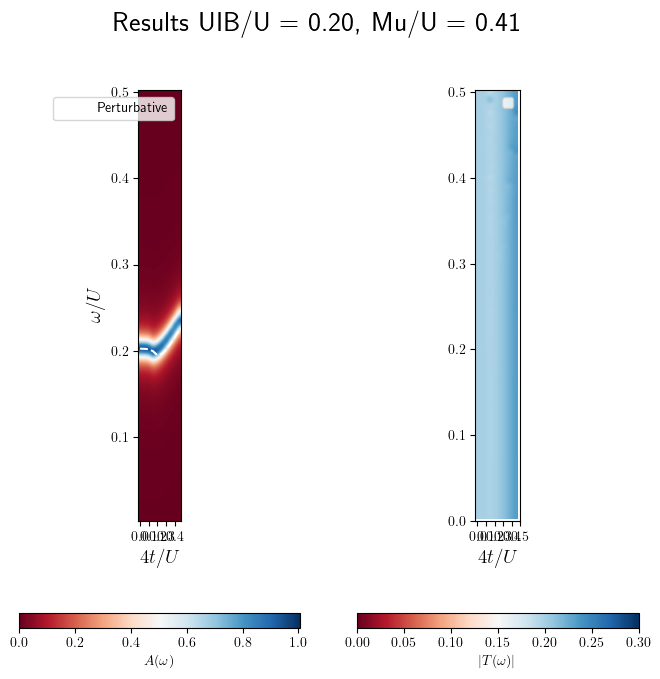

In [6]:
plt.rcParams['text.usetex'] = True

threshold = 0.00

filtered_SpectralFuncs = np.where(abs(SpectralFuncs) > threshold, SpectralFuncs, 0)


# Rotate the image by -90 degrees
SpectralFuncs_rot = np.rot90(filtered_SpectralFuncs, 1)
TFuncs_rot = np.rot90(TFuncs, 1)


fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12,8))

# Create the plot
# Set the aspect ratio to the ratio of the number of x points to the number of y points
aspect_ratio = 1
im1 = ax1.imshow(SpectralFuncs_rot, interpolation = 'bicubic', cmap='RdBu', aspect = aspect_ratio,label = "hey")
im2 = ax2.imshow(np.abs(TFuncs_rot), interpolation = 'bicubic',cmap='RdBu', aspect = aspect_ratio)

# Select a subset of dJUs and en_vector for the ticks
num_xticks = 6
num_yticks = 6

xticks = np.linspace(0, SpectralFuncs_rot.shape[1], num_xticks, endpoint=True, dtype=int)
yticks = np.linspace(0, SpectralFuncs_rot.shape[0], num_yticks, endpoint=True, dtype=int)

xticklabels = np.round(np.linspace(min(dJUs), max(dJUs), num_xticks), 2)
yticklabels = np.round(np.linspace(max(en_vector), min(en_vector), num_yticks), 2)

# Format the labels in LaTeX
xticklabels = [r'$\mathrm{{{}}}$'.format(label) for label in xticklabels]
yticklabels = [r'$\mathrm{{{}}}$'.format(label) for label in yticklabels]

ax1.set_xticks(xticks)
ax1.set_yticks(yticks)
ax2.set_xticks(xticks)
ax2.set_yticks(yticks)
ax1.set_xticklabels(xticklabels)
ax1.set_yticklabels(yticklabels)
ax2.set_xticklabels(xticklabels)
ax2.set_yticklabels(yticklabels)
ax1.set_xlabel(r'$4t/U$', fontsize=14)
ax2.set_xlabel(r'$4t/U$', fontsize=14)
ax1.set_ylabel(r'$\omega/U$', fontsize=14)

cb1 = plt.colorbar(im1,orientation="horizontal", label = "$A(\omega)$")
cb2 = plt.colorbar(im2,orientation="horizontal", label = "$|T(\omega)|$")
im2.set_clim(0, 0.3)



X, Y = np.meshgrid(dJUs, omega0s + omega1s + omega2s)
# ax2 = ax.twinx()
# Transform the y-coordinates of the plot to match the image coordinates
plot_x = np.interp(dJUs, (dJUs.min(), dJUs.max()), (0, SpectralFuncs_rot.shape[1]-1))
plot_y = SpectralFuncs_rot.shape[0] - 1 - np.interp(omega0s + omega1s + omega2s, (en_vector.min(), en_vector.max()), (0, SpectralFuncs_rot.shape[0]-1))
plot_y_pole = SpectralFuncs_rot.shape[0] - 1 - np.interp(pol_w, (en_vector.min(), en_vector.max()), (0, SpectralFuncs_rot.shape[0]-1))


# Overlay the plot on top of the imshow figure
ax1.plot(plot_x, plot_y, linestyle='--', label='Perturbative', color='white', linewidth=1.5)
#ax1.plot(plot_x[20:-1], plot_y_pole[20:-1], linestyle = ':', label='Lowest Pole T-matrix', color='green', linewidth=2)
#ax2.plot(plot_x[20:-1], plot_y_pole[20:-1], linestyle = ':', label='Lowest Pole T-matrix', color='green', linewidth=2)
ax1.legend()
ax2.legend()
fig.suptitle(f"Results UIB/U = {UIB:0.2f}, Mu/U = {muU:0.2f}", fontsize = 20)
plt.show()

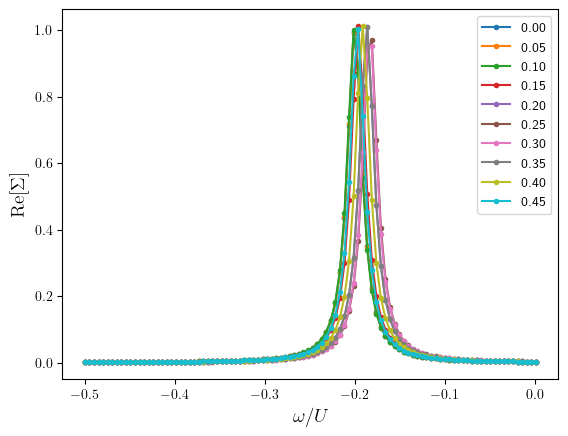

In [9]:
ind_list = range(0,num_dJU,10)
for ind in ind_list:
    plt.plot(en_vector,SpectralFuncs[ind,:],'.-',label = f"{dJUs[ind]:0.2f}")
plt.legend()
plt.xlabel(r'$\omega/U$', fontsize=14)
plt.ylabel(r'$\mathrm{Re}[\Sigma]$', fontsize=14)
#plt.yscale("log")
plt.show()

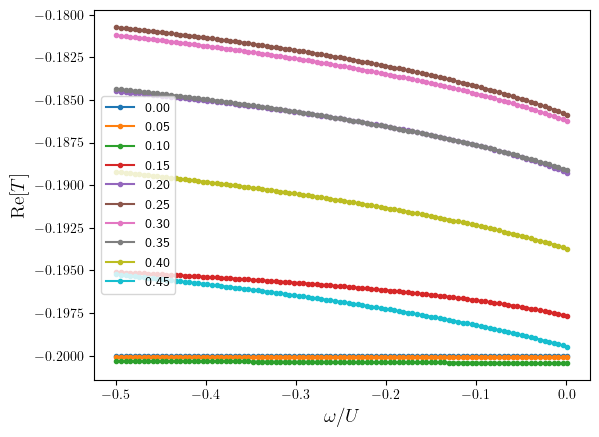

In [10]:
ind_list = range(0,num_dJU,10)
for ind in ind_list:
    plt.plot(en_vector,np.real(TFuncs[ind,:]),'.-',label = f"{dJUs[ind]:0.2f}")
plt.legend()
plt.xlabel(r'$\omega/U$', fontsize=14)
plt.ylabel(r'$\mathrm{Re}[T]$', fontsize=14)
#plt.yscale("log")
plt.show()

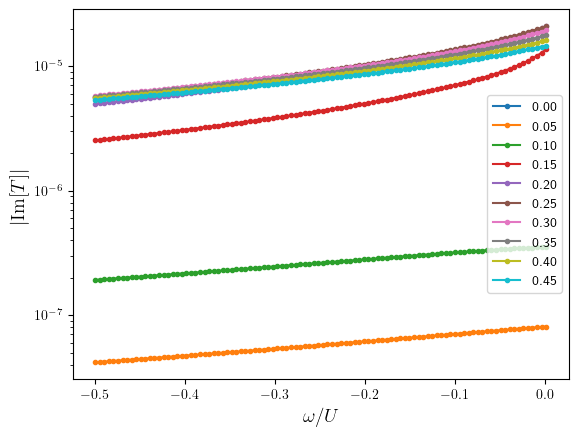

In [11]:
ind_list = range(0,num_dJU,10)
for ind in ind_list:
    plt.plot(en_vector,np.abs(np.imag(TFuncs[ind,:])),'.-',label = f"{dJUs[ind]:0.2f}")
plt.legend()
plt.xlabel(r'$\omega/U$', fontsize=14)
plt.ylabel(r'$|\mathrm{Im}[T]|$', fontsize=14)
plt.yscale("log")
plt.show()